In [0]:
# Style transfer is a way to transfer the style of a beautiful image like famous paintings to another image so that this new image is a mix or 
# some sort of fusion of the two images. to try it out check ' deep dream' : https://deepdreamgenerator.com/ 

#The idea behind it is you want to seperate the style and the content of a certain image. Like for example if we want to fuse a picture of a person
# with a van gough picture, you'd wanna preserve and extract just the style of the van gough painting not its content and fuse it with the content 
#of the image of a person so that you'd have a new picture that has both the person but with the style of van gough. 

#We're now gonna implement style transfer and I will explain along the way how could we seperate the style and the content of an image. 

#DISCLAIMER.... I'M MAINLY FOLLOWING THE UDACITY PYTORCH COURES... MOST OF THE CODE ON HERE IS NOT MY OWN...BUT ALL THE EXPLAINATIONS IS MINE...
#I HIGHLY ENCOURGE YOU TO LOOK AT THE ORIGINAL CODE : https://github.com/udacity/deep-learning-v2-pytorch/blob/master/style-transfer/Style_Transfer_Solution.ipynb 

In [1]:
#First I will upload the two pics I'm gonna work with... 
from google.colab import files
uploaded = files.upload()

Saving scarlet.jpg to scarlet.jpg
Saving style.jpg to style.jpg


In [5]:
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision

tcmalloc: large alloc 1073750016 bytes == 0x58688000 @  0x7fde627ac2a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641


In [0]:
#importing libs... 
%matplotlib inline

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
from torchvision import transforms, models
import os 

In [19]:
!pip install Pillow==4.0.0

    100% |████████████████████████████████| 5.6MB 7.3MB/s 
torchvision 0.2.1 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
  Found existing installation: Pillow 5.4.0
    Uninstalling Pillow-5.4.0:
      Successfully uninstalled Pillow-5.4.0


In [0]:
path = os.getcwd() 
content_path = path + "/scarlet.jpg" 
style_path = path+ "/style.jpg"

 **When you pass an image through a CNN you get a representation of what is in the image with no concern to color or shape or any "Style". **

**An image of a red car wouldn't be much different for a CNN than a black car when it's trying to classify it, and we will leverage that 
 to get a representation of the content of an image, since the later layers of a pretrained CNN have a pretty good representation of its content**


In [14]:
#load the features of a pretrained model, vgg19 
vgg = models.vgg19(pretrained = True).features

for param in vgg.parameters():
  param.requires_grad_(False) # we freeze every parameter in the network because we don't wanna change any of it. 
                              # the underscore at the end of 'requires_grad_' means that it will change the parametes inplace. 

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.torch/models/vgg19-dcbb9e9d.pth
100%|██████████| 574673361/574673361 [00:08<00:00, 70287611.22it/s]


In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # here we need to move our work to the gpu to speed up the process 

vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace)
  (18): MaxPool2d(kernel_size=2, stride=2, padding=0, 

**Now we create a function to load the images and convert them to tensors in order for us to be able to use them in the CNN. We're also gonna make sure they're of appropriate size and normalized**

In [0]:
def load_img(img_path, max_size = 400, shape = None):
  """A function that loads and prepares the images for the CNN""" 
  
  image = Image.open(img_path).convert('RGB') 
  
  if max(image.size) > max_size:
    
    size = max_size
  
  else:
    
    size = max(image.size) 
    
  if shape is not None:
    size = shape 
    
  #now we resize the image and convert it to a tensor and normalize it... 
  in_transforms = transforms.Compose([transforms.Resize(size),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.485, 0.456, 0.406), 
                                                        (0.229, 0.224, 0.225))]) 
  
  #since an image has a transperency channel alpha that we don't need, we're gonna remove it, [:3], and replace it with a batchsize
  image = in_transforms(image)[:3,:,:].unsqueeze(0)
  
  return image

In [0]:
# now we load the content image and the style image, and make sure both are of the same size... 
content = load_img(content_path).to(device) 

style = load_img(style_path, shape = content.shape[-2:]).to(device) # shape[-2:] yields the x-y dims of the image... 


In [0]:
#if we wanna visualize our images we need to create a helper function to UnNormalize the img and convert it to a numpy array to visualize it 
def img_convert(tensor):
  """Display a tensor as an img"""
  
  image = tensor.to("cpu").clone().detach()
  image = image.numpy().squeeze()
  image = image.transpose(1,2,0)
  image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
  image = image.clip(0,1)
  
  return image 
  

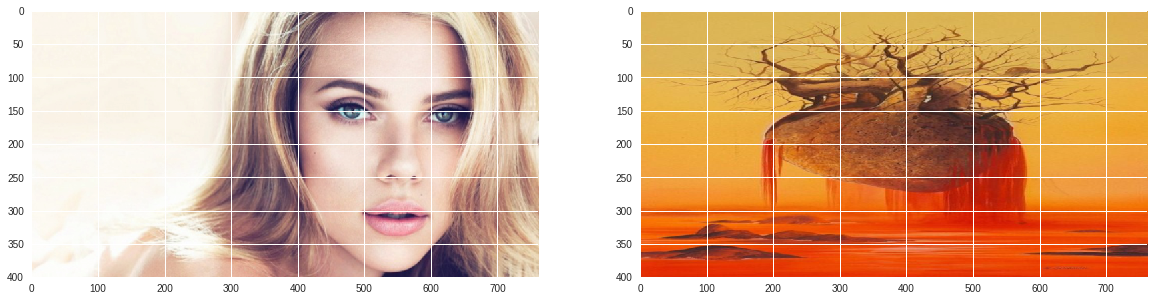

In [34]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(img_convert(content))
ax2.imshow(img_convert(style))

**Now we need to keep track of the layers that we wanna extract features from**

In [0]:
def get_features(image, model, layers= None):
  """A function to go through the whole network and store the relevent features from the selected layers""" 
  if layers is None:
    layers =  {'0': 'conv1_1',
                  '5': 'conv2_1', 
                  '10': 'conv3_1', 
                  '19': 'conv4_1',
                  '21': 'conv4_2',  ## content representation
                  '28': 'conv5_1'}
  features = {} 
  x = image 
  for name, layer in model._modules.items():
    x = layer(x) 
    if name in layers:
      features[layers[name]] = x
  
  return features

##Gram Matrix 

simply, gram matrices are matrices that have information about the style of a image. 

We get the features of the first layers of each conv block, which is kind of intuitive because those layer will most likely still preserve how the image look like and what's its styalistic characteristics 

You can calculate the gram matrix as follows : 


*   Get the depth, height, and width of a tensor using batch_size, d, h, w = tensor.size

*    Reshape that tensor so that the spatial dimensions are flattened

*    Calculate the gram matrix by multiplying the reshaped tensor by it's transpose



In [0]:
def gram_matrix(tensor):
  """Calculate the gram matrix of a tensor"""
  
  _, D, H, W = tensor.size() # get the dims 
  
  tensor = tensor.view(D, H*W) # Flatten it or vectorize it 
  
  gram = torch.mm(tensor, tensor.t()) # calculate the gram matrix 
  
  return gram 
  
  

In [0]:
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features} 

target = content.clone().requires_grad_(True).to(device)

In [0]:
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

content_weight = 1  # alpha
style_weight = 1e6  # beta

Total loss:  19651684.0


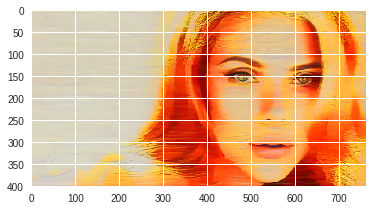

Total loss:  5584500.5


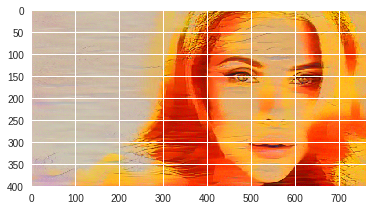

Total loss:  1893644.125


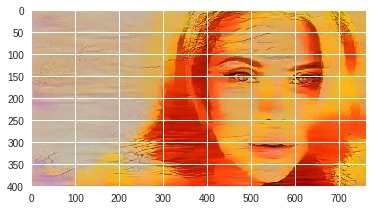

Total loss:  779555.25


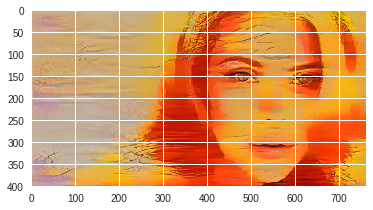

Total loss:  447316.1875


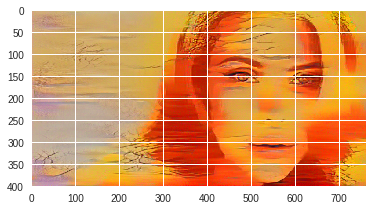

In [45]:
show_every = 400

# iteration hyperparameters
optimizer = optim.Adam([target], lr=0.003)
steps = 2000  # decide how many iterations to update your image (5000)

for ii in range(1, steps+1):
    
    # get the features from your target image
    target_features = get_features(target, vgg)
    
    # the content loss
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
    
    # the style loss
    # initialize the style loss to 0
    style_loss = 0
    # then add to it for each layer's gram matrix loss
    for layer in style_weights:
        # get the "target" style representation for the layer
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        _, d, h, w = target_feature.shape
        # get the "style" style representation
        style_gram = style_grams[layer]
        # the style loss for one layer, weighted appropriately
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        # add to the style loss
        style_loss += layer_style_loss / (d * h * w)
        
    # calculate the *total* loss
    total_loss = content_weight * content_loss + style_weight * style_loss
    
    # update your target image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    # display intermediate images and print the loss
    if  ii % show_every == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(img_convert(target))
        plt.show()

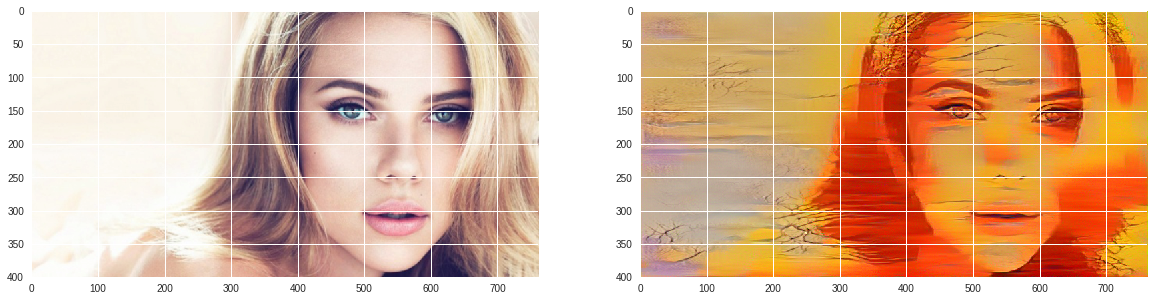

In [47]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(img_convert(content))
ax2.imshow(img_convert(target))

In [81]:
target2 = target.clone() 
target2 = img_convert(target2) 
target2.shape[:2]

(400, 762)

In [0]:
# img = Image.fromarray(target2)

In [84]:
import scipy.misc
scipy.misc.imsave('outfile.jpg', target2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  


In [85]:
os.listdir()

['.config',
 'style.jpg',
 'scarlet.jpg',
 'outfile.jpg',
 'out.jpg',
 'sample_data']

In [0]:
files.download("outfile.jpg")